Nama : Aditya Atadewa  
Kelas : TI 3G  
NIM : 2341720174  
Absen : 01  

# Studi Kasus Pembelajaran Mesin: Clustering dan Approximate Nearest Neighbor (ANN)
### Dataset: House Prices – Advanced Regression Techniques (Kaggle)

## 1. Import Library

In [57]:
!pip install -q annoy seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

from annoy import AnnoyIndex


## 2. Load Dataset

In [58]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Machine Learning - 2025/UTS/dataset/train.csv'

df = pd.read_csv(path)
print("Jumlah data dan kolom:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jumlah data dan kolom: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Cek Info Dataset

In [59]:

df.info()
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nKolom dengan missing values:")
print(missing)
df.describe().T.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


## 4. Data Preprocessing

In [60]:

df_prep = df.copy()
num_cols = df_prep.select_dtypes(include=[np.number]).columns
cat_cols = df_prep.select_dtypes(exclude=[np.number]).columns

for c in num_cols:
    if df_prep[c].isnull().any():
        df_prep[c] = df_prep[c].fillna(df_prep[c].median())

for c in cat_cols:
    if df_prep[c].isnull().any():
        df_prep[c] = df_prep[c].fillna(df_prep[c].mode()[0])

print("Jumlah missing values setelah imputasi:", df_prep.isnull().sum().sum())


Jumlah missing values setelah imputasi: 0


## 5. Pembuatan Fitur Baru

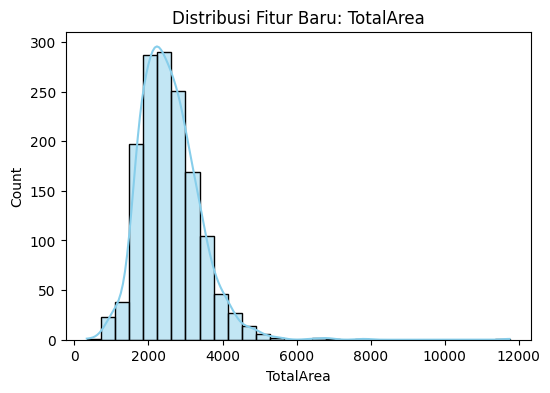

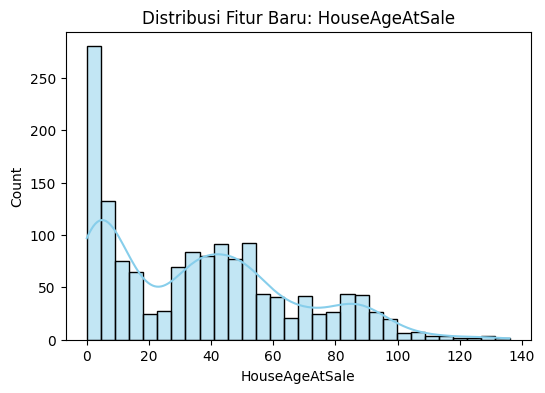

In [61]:

df_prep['TotalArea'] = df_prep['GrLivArea'] + df_prep['TotalBsmtSF']
df_prep['HouseAgeAtSale'] = df_prep['YrSold'] - df_prep['YearBuilt']

plt.figure(figsize=(6,4))
sns.histplot(df_prep['TotalArea'], kde=True, bins=30, color='skyblue')
plt.title("Distribusi Fitur Baru: TotalArea")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_prep['HouseAgeAtSale'], kde=True, bins=30, color='skyblue')
plt.title("Distribusi Fitur Baru: HouseAgeAtSale")
plt.show()


## 6. Standarisasi Data

In [62]:

drop_cols = ['Id', 'SalePrice']
features = [c for c in df_prep.select_dtypes(include=[np.number]).columns if c not in drop_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_prep[features])

print("Shape data setelah scaling:", X_scaled.shape)


Shape data setelah scaling: (1460, 38)


## 7. Clustering dengan KMeans

In [63]:

best_k, best_sil, best_dbi = None, -1, None
best_kmeans_labels = None

sil_scores, dbi_scores = [], []

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels, sample_size=500, random_state=42)
    dbi = davies_bouldin_score(X_scaled, labels)
    sil_scores.append((k, sil))
    dbi_scores.append((k, dbi))

    if sil > best_sil:
        best_k, best_sil, best_dbi = k, sil, dbi
        best_kmeans_labels = labels

print("Silhouette by k:", sil_scores)
print("DBI by k:", dbi_scores)
print(f"\nBest KMeans: k={best_k} | Silhouette={best_sil:.4f} | DBI={best_dbi:.4f}")


Silhouette by k: [(2, np.float64(0.16662662881503393)), (3, np.float64(0.1420172825683872)), (4, np.float64(0.12542374924508382)), (5, np.float64(0.10418815140292753)), (6, np.float64(0.10000978173174892)), (7, np.float64(0.095007673861695)), (8, np.float64(0.10951990801868858))]
DBI by k: [(2, np.float64(2.206151071627008)), (3, np.float64(2.456040373352358)), (4, np.float64(2.605493262160169)), (5, np.float64(2.4468177662468866)), (6, np.float64(2.450232028270345)), (7, np.float64(2.4135253538026595)), (8, np.float64(2.2075024204284963))]

Best KMeans: k=2 | Silhouette=0.1666 | DBI=2.2062


## 8. Visualisasi KMeans (PCA 2D)

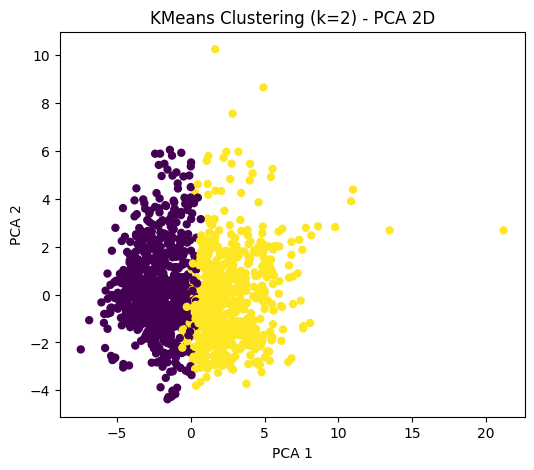

In [64]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=best_kmeans_labels, cmap='viridis', s=25)
plt.title(f"KMeans Clustering (k={best_k}) - PCA 2D")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.show()


## 9. Clustering dengan DBSCAN (Tuning Parameter)

In [65]:

candidate_eps = [1.0, 1.5, 2.0, 2.5, 3.0]
candidate_min_samples = [5, 10]

best_dbscan_labels = None
best_sil_db, best_dbi_db = -1, None
best_params = None
grid_results = []

for eps in candidate_eps:
    for ms in candidate_min_samples:
        dbs = DBSCAN(eps=eps, min_samples=ms)
        labels = dbs.fit_predict(X_scaled)

        if len(set(labels)) > 1:
            sil = silhouette_score(X_scaled, labels, sample_size=500, random_state=42)
            dbi = davies_bouldin_score(X_scaled, labels)
            grid_results.append((eps, ms, len(set(labels))-1, sil, dbi))

            if sil > best_sil_db:
                best_sil_db, best_dbi_db = sil, dbi
                best_params, best_dbscan_labels = (eps, ms), labels

print("\nGrid Results (eps, min_samples, n_clusters, Silhouette, DBI):")
for r in grid_results: print(r)
print(f"\nBest DBSCAN: eps={best_params[0]}, min_samples={best_params[1]} | Silhouette={best_sil_db:.4f} | DBI={best_dbi_db:.4f}")



Grid Results (eps, min_samples, n_clusters, Silhouette, DBI):
(1.5, 5, 2, np.float64(-0.18208087340135798), np.float64(1.8514561259559132))
(2.0, 5, 7, np.float64(-0.28569777418756587), np.float64(1.771339285822621))
(2.0, 10, 2, np.float64(-0.16485096249755365), np.float64(2.0479151442581265))
(2.5, 5, 10, np.float64(-0.21800037192562008), np.float64(2.0054321329593034))
(2.5, 10, 6, np.float64(-0.24743326044867217), np.float64(2.1528947834973904))
(3.0, 5, 8, np.float64(-0.14527978099425168), np.float64(2.459201130629193))
(3.0, 10, 4, np.float64(-0.08616252231032581), np.float64(2.5853982943594405))

Best DBSCAN: eps=3.0, min_samples=10 | Silhouette=-0.0862 | DBI=2.5854


## 10. Visualisasi Hasil Tuning DBSCAN

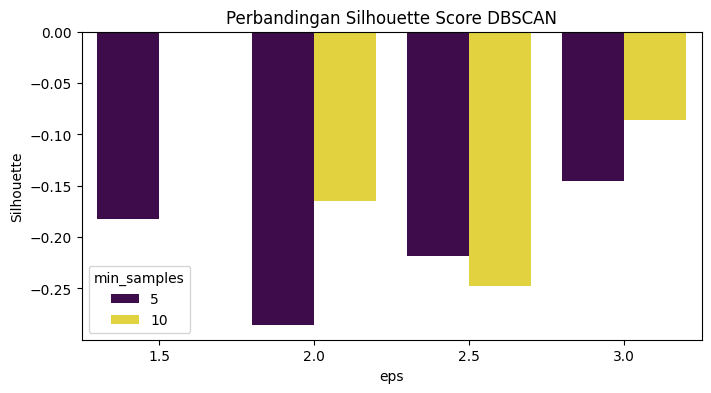

In [66]:

results_df = pd.DataFrame(grid_results, columns=['eps','min_samples','n_clusters','Silhouette','DBI'])
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x='eps', y='Silhouette', hue='min_samples', palette='viridis')
plt.title("Perbandingan Silhouette Score DBSCAN")
plt.show()


## 11. Visualisasi DBSCAN (PCA 2D)

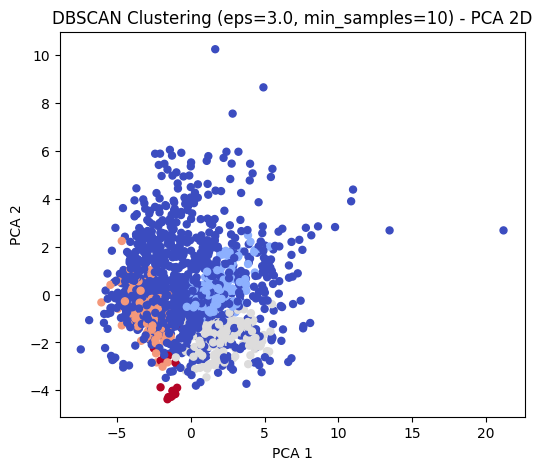

In [67]:

if best_dbscan_labels is not None:
    plt.figure(figsize=(6,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=best_dbscan_labels, cmap='coolwarm', s=25)
    plt.title(f"DBSCAN Clustering (eps={best_params[0]}, min_samples={best_params[1]}) - PCA 2D")
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.show()


## 12. Approximate Nearest Neighbor (ANN) menggunakan Annoy

In [68]:
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Build index sekali saja (sama untuk kedua model)
for i in range(X_scaled.shape[0]):
    ann.add_item(i, X_scaled[i])
ann.build(10)

# Pilih 3 titik acak sebagai query
rng = np.random.default_rng(42)
query_indices = rng.choice(X_scaled.shape[0], size=3, replace=False)

# -------------------------------
# Bagian 1: Analisis KMEANS
# -------------------------------
print("=== ANALISIS ANN UNTUK KMEANS ===")
for q in query_indices:
    neighbors, distances = ann.get_nns_by_item(q, 5, include_distances=True)
    cluster_q = best_kmeans_labels[q]
    print(f"\nQuery index: {q} | Cluster (KMeans): {cluster_q}")

    for n, d in zip(neighbors, distances):
        cluster_n = best_kmeans_labels[n]
        print(f"  Neighbor: {n:4d} | Dist: {d:8.4f} | Cluster (KMeans): {cluster_n}")

# -------------------------------
# Bagian 2: Analisis DBSCAN
# -------------------------------
if 'best_dbscan_labels' in locals() and best_dbscan_labels is not None:
    print("\n=== ANALISIS ANN UNTUK DBSCAN ===")

    for q in query_indices:
        neighbors, distances = ann.get_nns_by_item(q, 5, include_distances=True)
        cluster_q = best_dbscan_labels[q]
        print(f"\nQuery index: {q} | Cluster (DBSCAN): {cluster_q}")

        for n, d in zip(neighbors, distances):
            cluster_n = best_dbscan_labels[n]
            print(f"  Neighbor: {n:4d} | Dist: {d:8.4f} | Cluster (DBSCAN): {cluster_n}")
else:
    print("\n DBSCAN belum menghasilkan cluster valid, jadi tidak bisa dianalisis dengan ANN.")


=== ANALISIS ANN UNTUK KMEANS ===

Query index: 955 | Cluster (KMeans): 0
  Neighbor:  955 | Dist:   0.0000 | Cluster (KMeans): 0
  Neighbor: 1275 | Dist:   2.2277 | Cluster (KMeans): 0
  Neighbor:  505 | Dist:   2.9885 | Cluster (KMeans): 0
  Neighbor:  913 | Dist:   3.3839 | Cluster (KMeans): 0
  Neighbor: 1062 | Dist:   5.0132 | Cluster (KMeans): 0

Query index: 130 | Cluster (KMeans): 1
  Neighbor:  130 | Dist:   0.0000 | Cluster (KMeans): 1
  Neighbor:  279 | Dist:   3.2525 | Cluster (KMeans): 1
  Neighbor:  988 | Dist:   3.5174 | Cluster (KMeans): 1
  Neighbor: 1111 | Dist:   3.5673 | Cluster (KMeans): 1
  Neighbor: 1315 | Dist:   3.7262 | Cluster (KMeans): 1

Query index: 1129 | Cluster (KMeans): 0
  Neighbor: 1129 | Dist:   0.0000 | Cluster (KMeans): 0
  Neighbor:  779 | Dist:   2.0620 | Cluster (KMeans): 0
  Neighbor:  547 | Dist:   2.9776 | Cluster (KMeans): 0
  Neighbor:   42 | Dist:   3.2596 | Cluster (KMeans): 0
  Neighbor:   71 | Dist:   3.3146 | Cluster (KMeans): 0

=== 

## 13. Visualisasi ANN

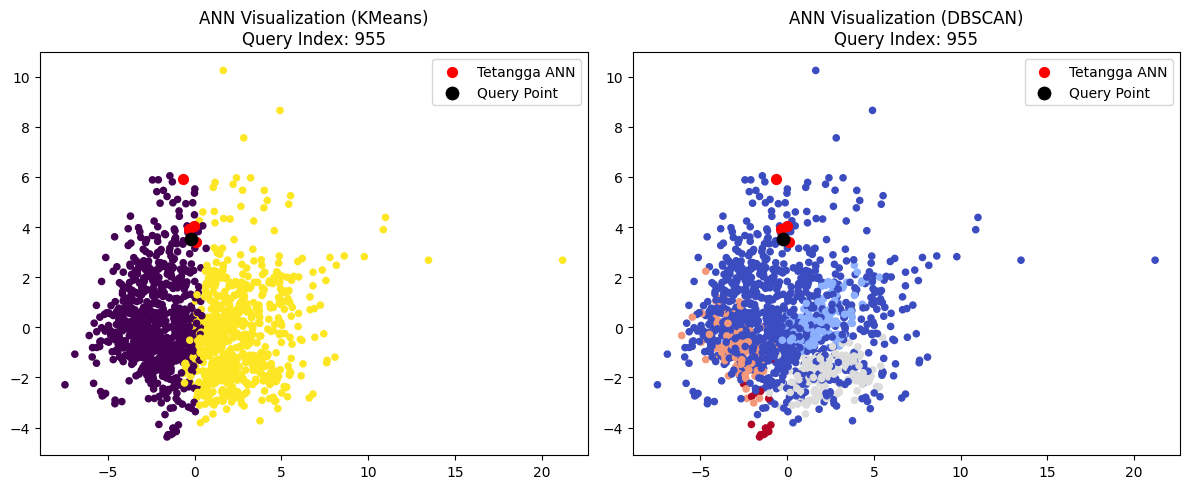

In [69]:
query_idx = query_indices[0]
neighbors, distances = ann.get_nns_by_item(query_idx, 5, include_distances=True)

plt.figure(figsize=(12,5))

# -----------------------------------
# Visualisasi ANN untuk KMEANS
# -----------------------------------
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=best_kmeans_labels, cmap='viridis', s=20)
plt.scatter(X_pca[neighbors,0], X_pca[neighbors,1], color='red', s=50, label='Tetangga ANN')
plt.scatter(X_pca[query_idx,0], X_pca[query_idx,1], color='black', s=80, label='Query Point')
plt.legend()
plt.title(f"ANN Visualization (KMeans)\nQuery Index: {query_idx}")

# -----------------------------------
# Visualisasi ANN untuk DBSCAN
# -----------------------------------
if 'best_dbscan_labels' in locals() and best_dbscan_labels is not None:
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=best_dbscan_labels, cmap='coolwarm', s=20)
    plt.scatter(X_pca[neighbors,0], X_pca[neighbors,1], color='red', s=50, label='Tetangga ANN')
    plt.scatter(X_pca[query_idx,0], X_pca[query_idx,1], color='black', s=80, label='Query Point')
    plt.legend()
    plt.title(f"ANN Visualization (DBSCAN)\nQuery Index: {query_idx}")
else:
    print("DBSCAN belum menghasilkan cluster valid, tidak dapat divisualisasikan.")

plt.tight_layout()
plt.show()

## 14. Ringkasan Evaluasi

In [70]:
print(f"KMeans terbaik: k={best_k} | Silhouette={best_sil:.3f} | DBI={best_dbi:.3f}")
print(f"DBSCAN terbaik: eps={best_params[0]} | min_samples={best_params[1]} | Silhouette={best_sil_db:.3f} | DBI={best_dbi_db:.3f}")

KMeans terbaik: k=2 | Silhouette=0.167 | DBI=2.206
DBSCAN terbaik: eps=3.0 | min_samples=10 | Silhouette=-0.086 | DBI=2.585


## 15. Kesimpulan

- Berdasarkan hasil analisis, model **KMeans** menghasilkan performa clustering yang lebih stabil dengan Silhouette positif (0.16) dan Davies–Bouldin Index lebih rendah (2.20).  
- Model **DBSCAN** cenderung memberikan Silhouette negatif karena sensitif terhadap skala data dan parameter, menunjukkan cluster yang kurang terpisah.  
- Hasil **ANN (Annoy)** menunjukkan bahwa tetangga terdekat dari suatu titik cenderung berada pada cluster KMeans yang sama, sehingga struktur cluster terjaga.  
- Dengan demikian, **KMeans** lebih sesuai digunakan untuk dataset **House Prices** karena hasilnya konsisten, stabil, dan lebih mudah diinterpretasikan.